# Packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import harmonypy as hm
from modules.visualize import *
from modules.deg_analysis import *
import seaborn as sns
from collections import Counter
from MCML.modules import MCML, bMCML
from MCML import tools as tl
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, r
from scipy.sparse import csr_matrix
from scipy.sparse import issparse

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-16 17:24:12.002954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 17:24:12.695827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pandas2ri.activate()
anndata2ri.activate()
# Install and load necessary R packages
#robjects.r('BiocManager::install("scran", update=FALSE, force=TRUE)')
#ro.r('BiocManager::install("scry", update=FALSE, force=TRUE)')
#ro.r('BiocManager::install("SingleCellExperiment", update=FALSE, force=TRUE)')
ro.r('library(scran)')
ro.r('library(BiocParallel)')
ro.r('library(scry)')
ro.r('library(SingleCellExperiment)')

/tmp/ipykernel_4678/3141930173.py:2: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, col

In [3]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, facecolor="white", frameon=False)
rcb.logger.setLevel(logging.ERROR)

# Import dataset

In [4]:
sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
                      'SampleTag18_flex':'3xTg-DMSO',
                      'SampleTag19_flex':'WT-SCDi',
                      'SampleTag20_flex':'3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}
adata = anndata.read_h5ad('data/fede_count.h5ad')
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)
anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)

# Annotate cells (MapMyCells)

In [5]:
adata = annotate_adata(adata, anno_df)

# Exploratory data analysis

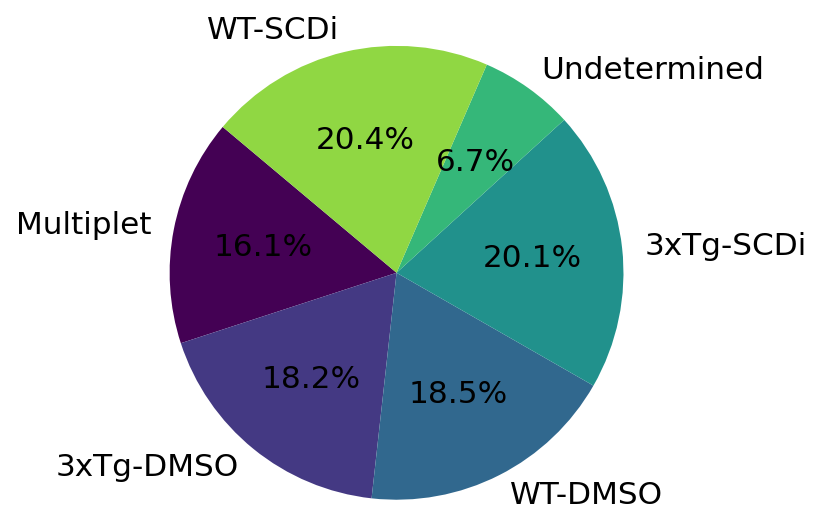

In [17]:
pie_chart_condition(adata.obs['Sample_Tag'].values)

In [25]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['high_mt'] = adata.obs['pct_counts_mt'] > 50

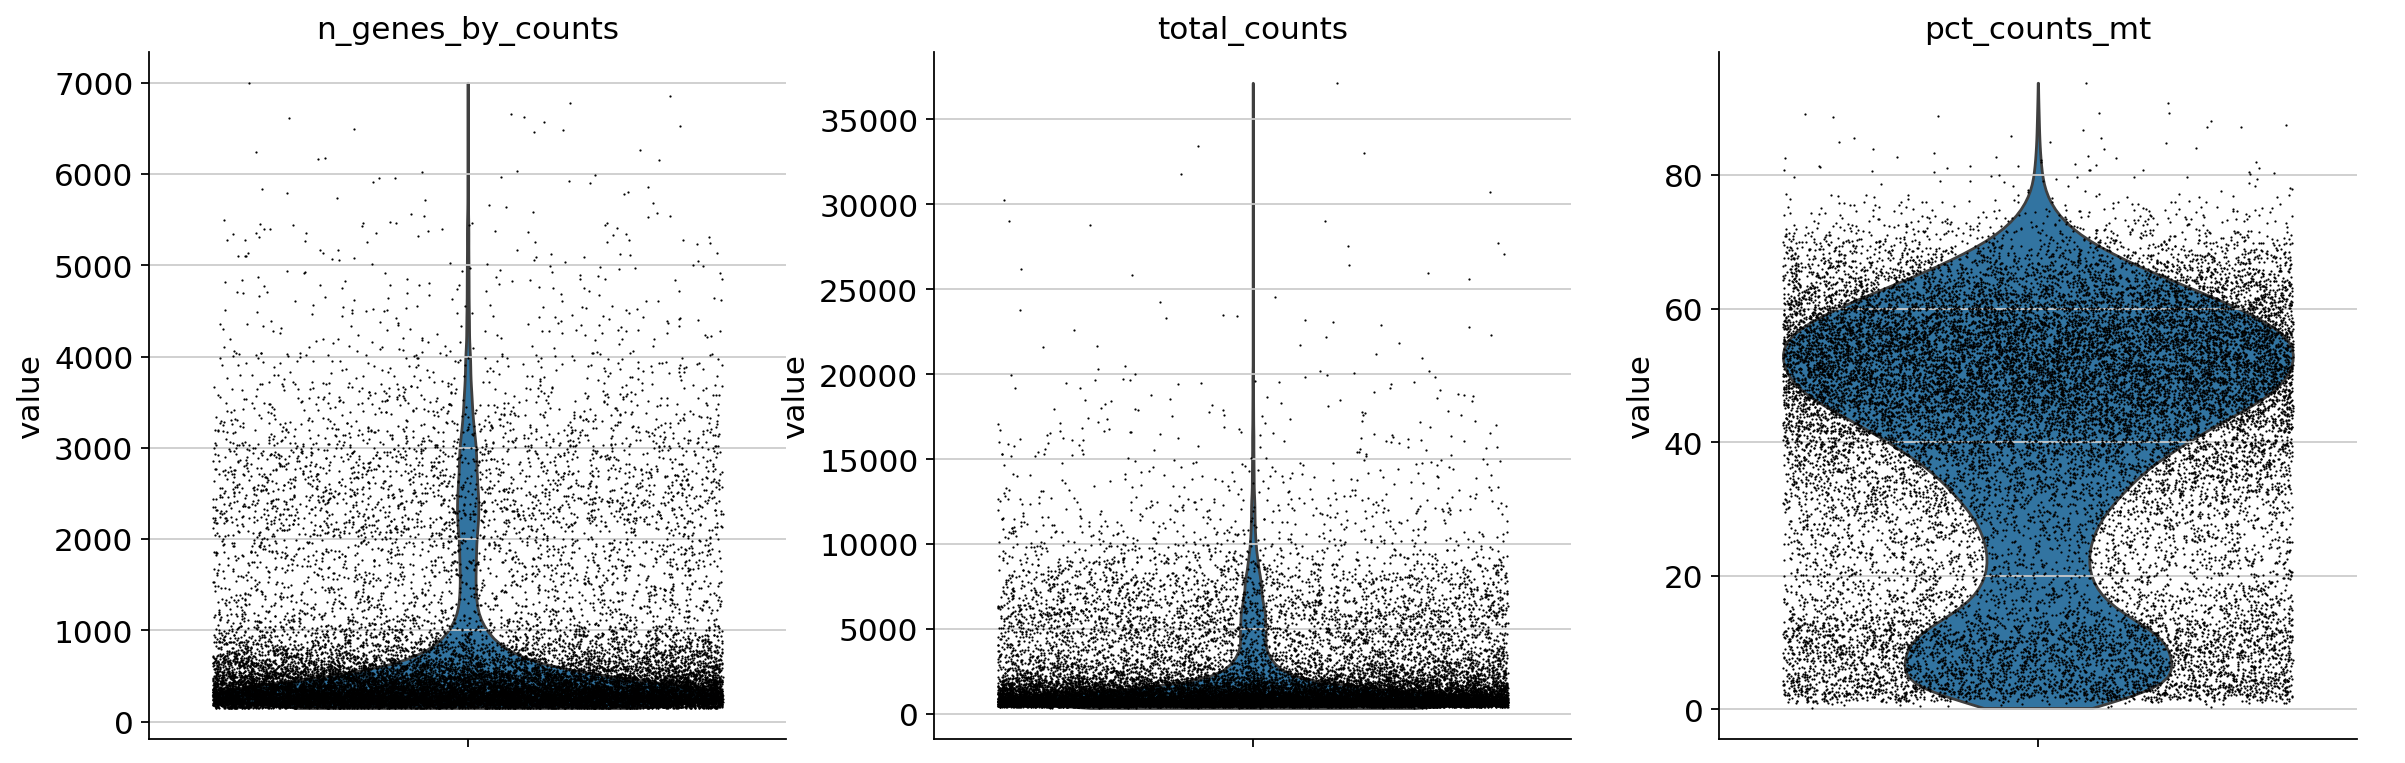

In [26]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save='violin.png')

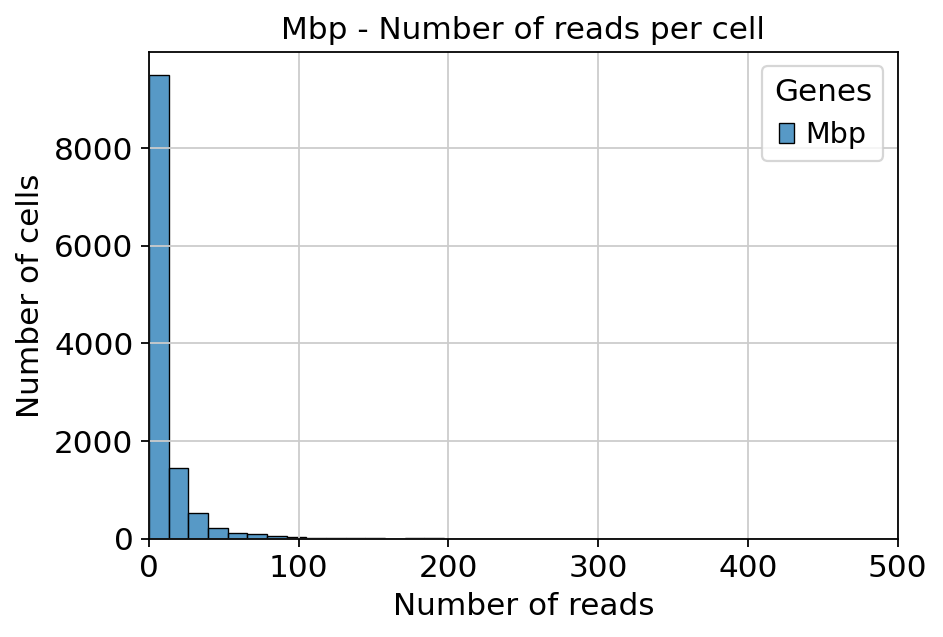

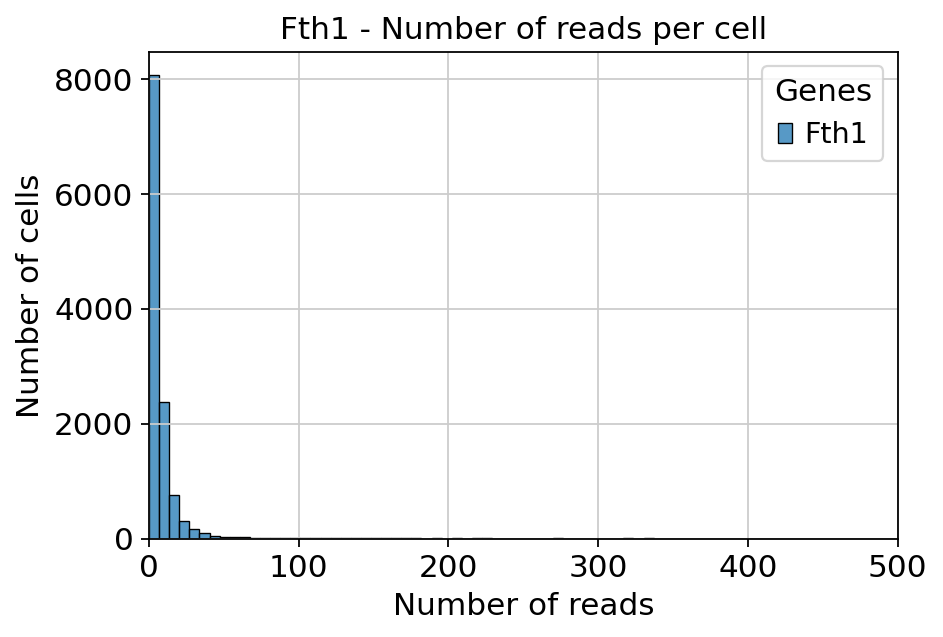

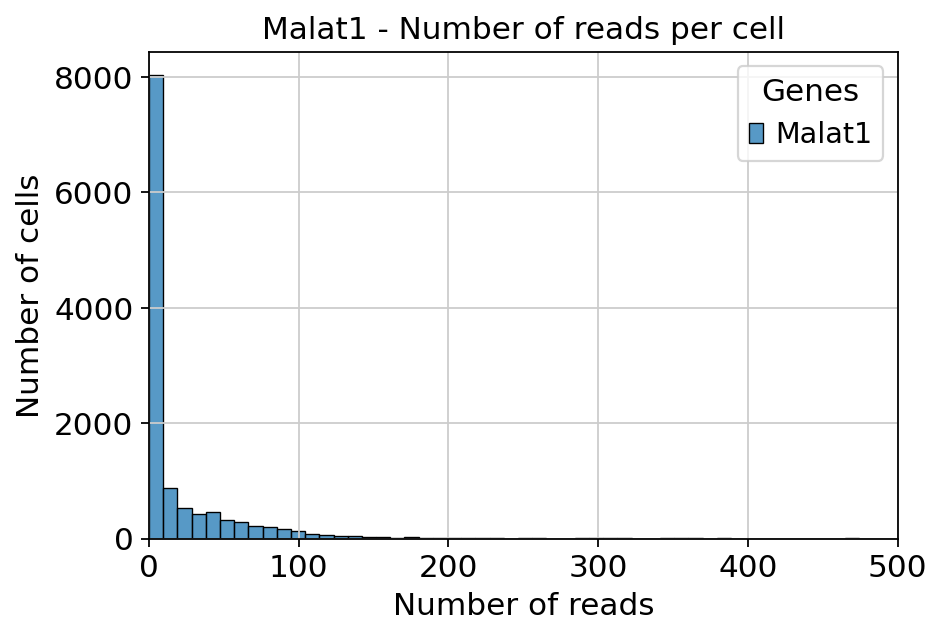

In [49]:
plot_top_n_distr(adata, top_n=3)

/tmp/ipykernel_4678/3671720741.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


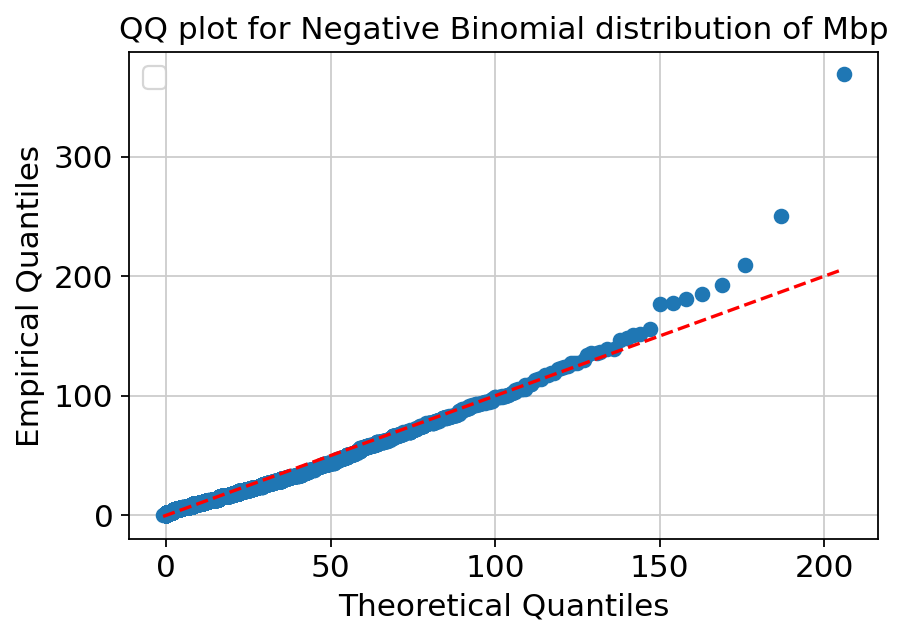

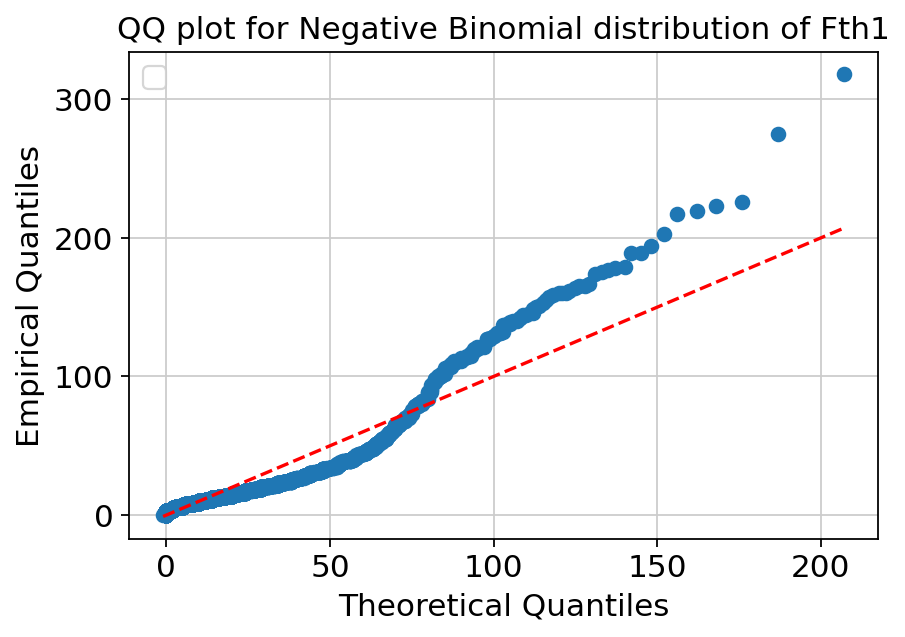

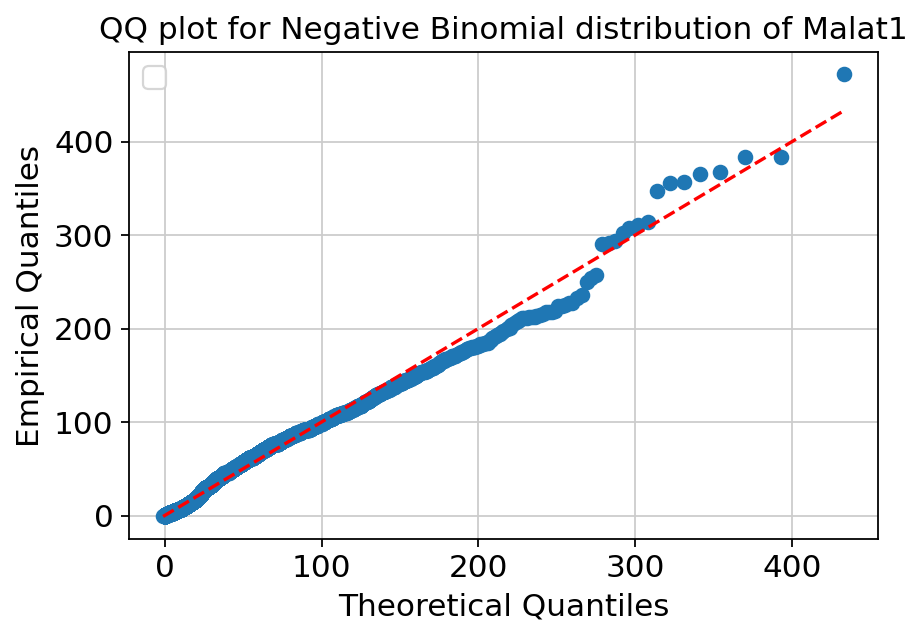

In [45]:
plot_top_genes_qq(adata, top_n=3)

# Quality control

In [28]:
sc.pp.filter_cells(adata, min_genes=150)
sc.pp.filter_genes(adata, min_cells=3)

In [29]:
adata = adata[~adata.obs['high_mt'], :]
adata = adata[adata.obs['Sample_Tag'] != "Multiplet", :]

# Normalization

In [30]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


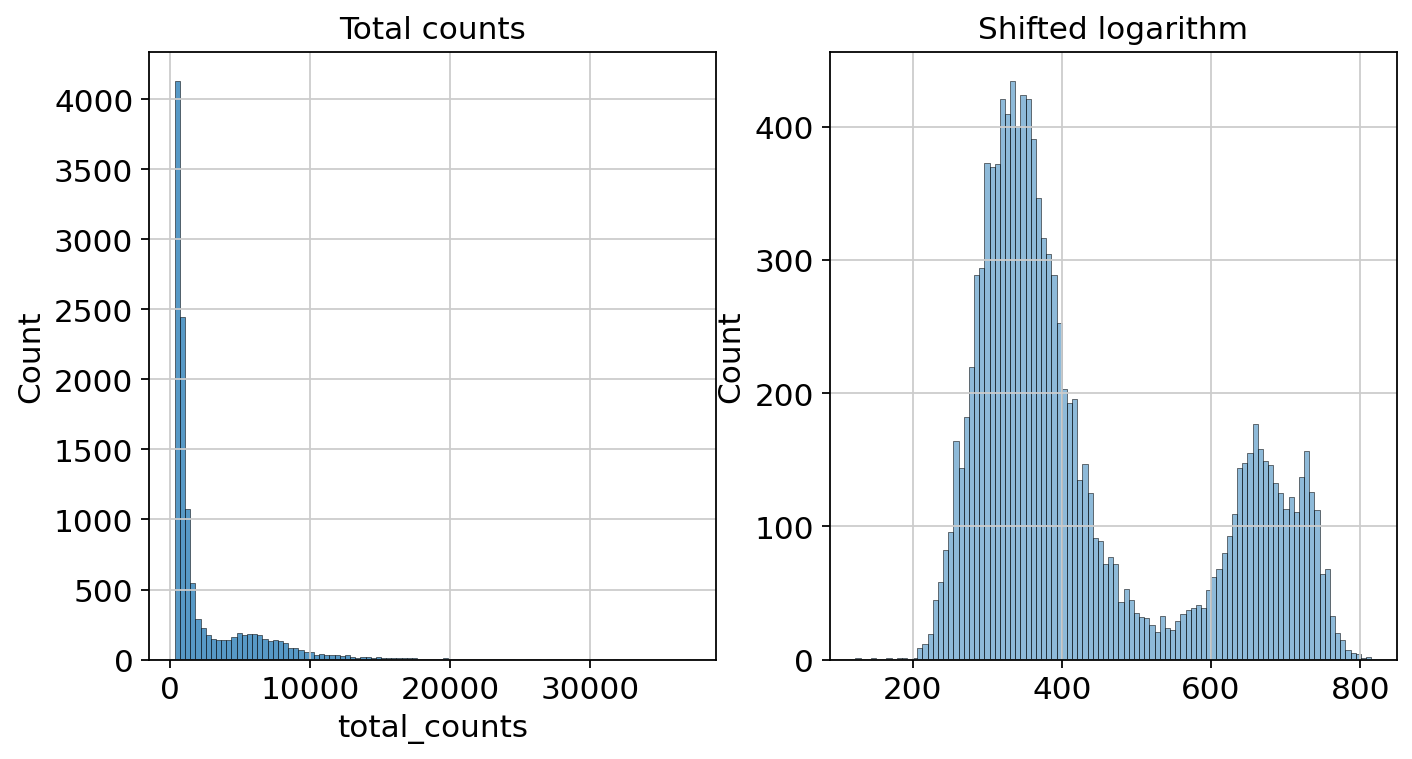

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
axes[1].legend_.remove()
plt.show()

# Save adata object

In [32]:
adata.write("data/fede_count_normalized.h5ad")

# Select features

In [33]:
adata.X = adata.X.astype(np.float32)
ro.globalenv['adata'] = anndata2ri.py2rpy(adata)
ro.r('sce <- as(adata, "SingleCellExperiment")')
ro.r('sce <- devianceFeatureSelection(sce, assay="X")')
binomial_deviance = np.array(ro.r('rowData(sce)$binomial_deviance')).T
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True
adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False, layer='log1p_norm')

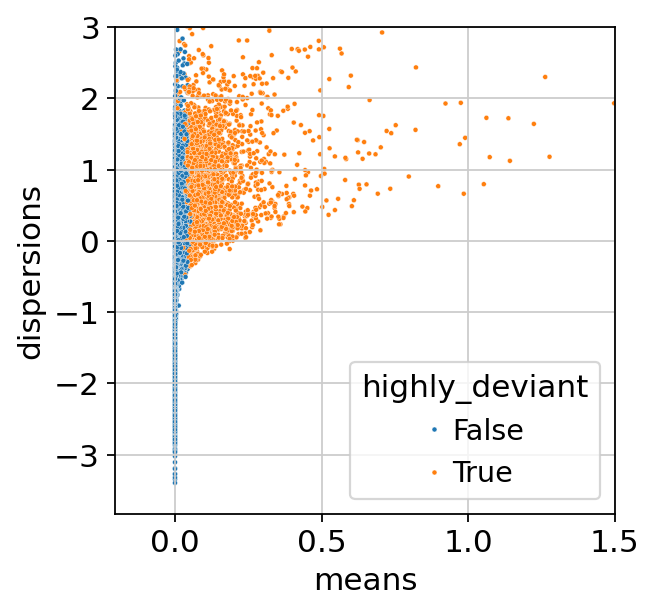

In [34]:
ax = sns.scatterplot(data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

# Dimensionality reduction

### Principal component analysis (PCA)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


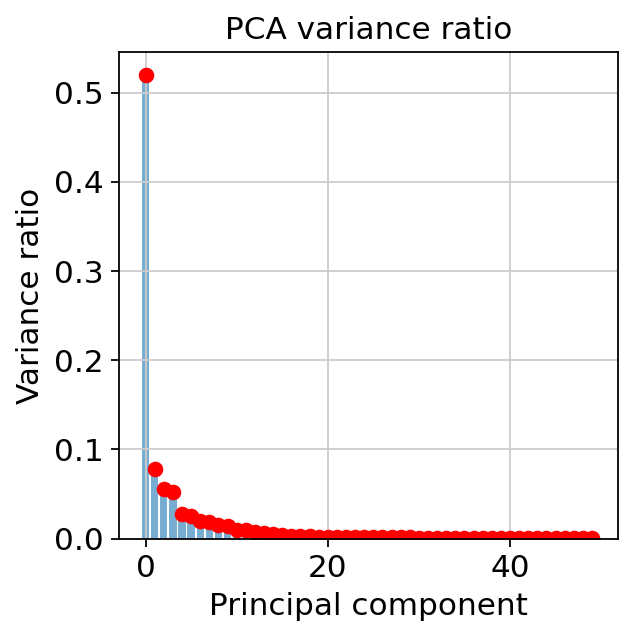

In [35]:
elbow_plot(adata, save_path='figures/elbow_plot.png')

In [36]:
sc.tl.pca(adata, n_comps=10, use_highly_variable=True)

### Multi-class multi-label (MCML)

In [37]:
subclass_name = adata.obs['subclass_name'].values.tolist()
sample_tag = adata.obs['Sample_Tag'].values.tolist()

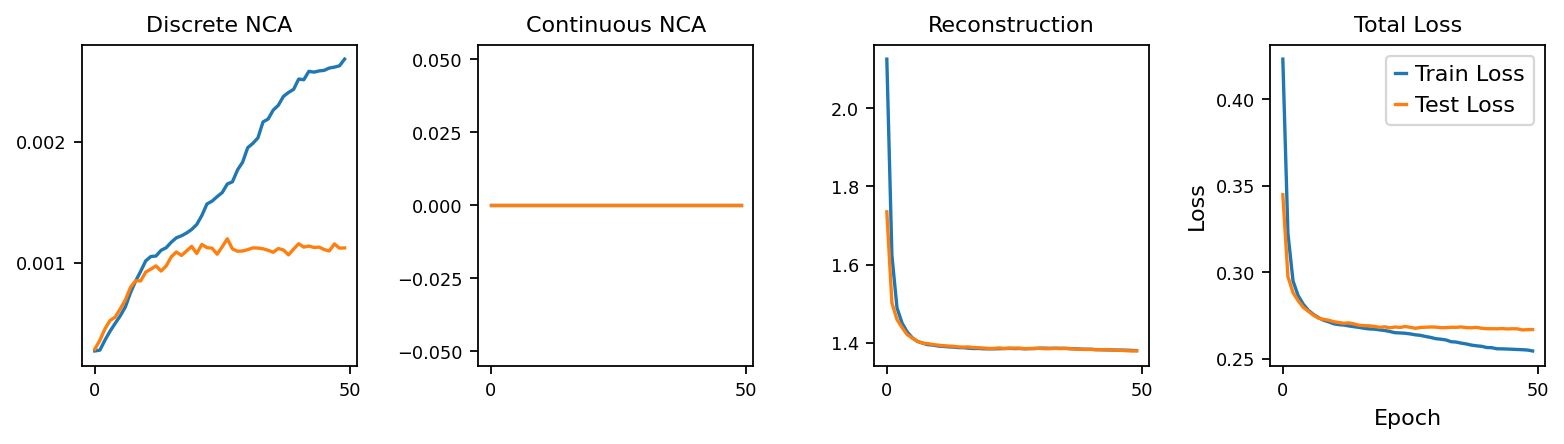

In [50]:
mcml = MCML(n_latent = 50, epochs = 50)
latentMCML = mcml.trainTest(adata.layers['log1p_norm'].toarray(), np.array([subclass_name]), fracNCA = 0.8, silent = True)
mcml.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8, fname=None)

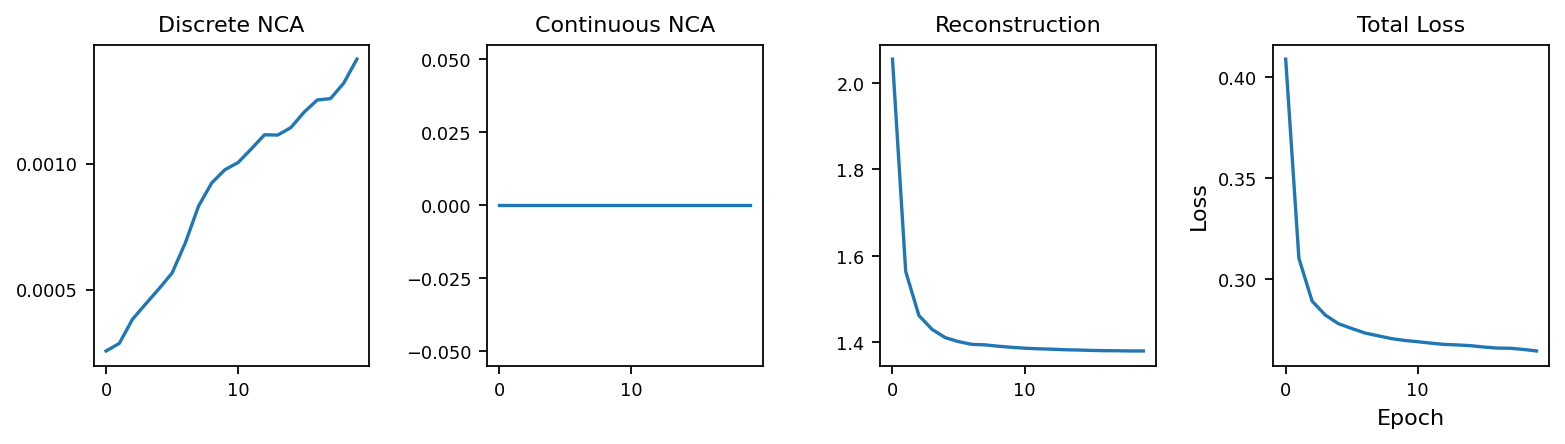

In [51]:
mcml = MCML(n_latent = 50, epochs = 20)
latentMCML = mcml.fit(adata.layers['log1p_norm'].toarray(), np.array([subclass_name]), fracNCA = 0.8, silent = True)
mcml.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8, fname=None)

In [52]:
adata.obsm['X_mcml'] = latentMCML
mcml_latents = adata.obsm['X_mcml']

# Batch correction

In [ ]:
harmony_out = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'Sample_Tag')
adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T

# Clustering

In [74]:
sc.pp.neighbors(adata, use_rep='X_mcml', n_pcs=50)
sc.tl.leiden(adata, resolution=0.25)

In [75]:
assign_unique_cell_type_names(adata, cluster_key='leiden', cluster_types=['class_name', 'subclass_name', 'supertype_name'])

# Visualization

In [76]:
sc.tl.umap(adata)

In [77]:
sc.tl.tsne(adata)

### Leiden cluster visualization

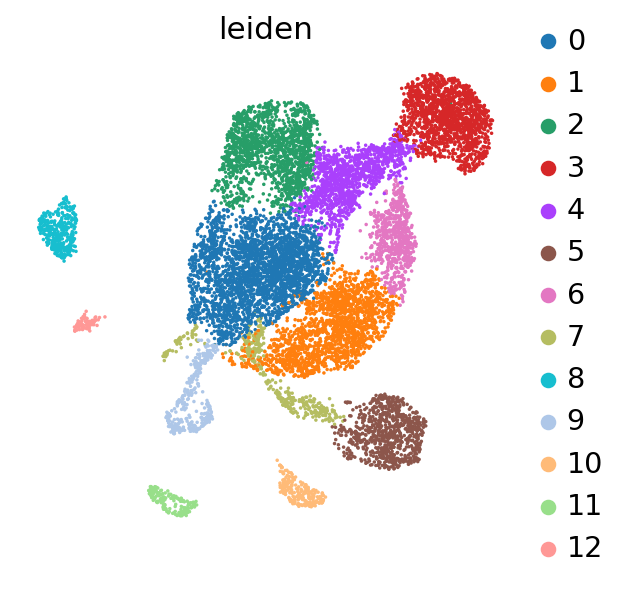

In [78]:
sc.pl.umap(adata, color=['leiden'], save='_leiden.png')

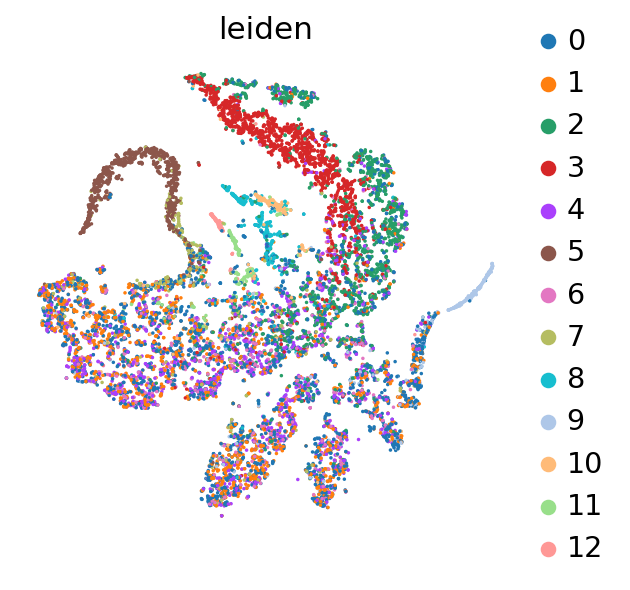

In [79]:
sc.pl.tsne(adata, color=['leiden'], save='_leiden.png')

### Experimental group visualization

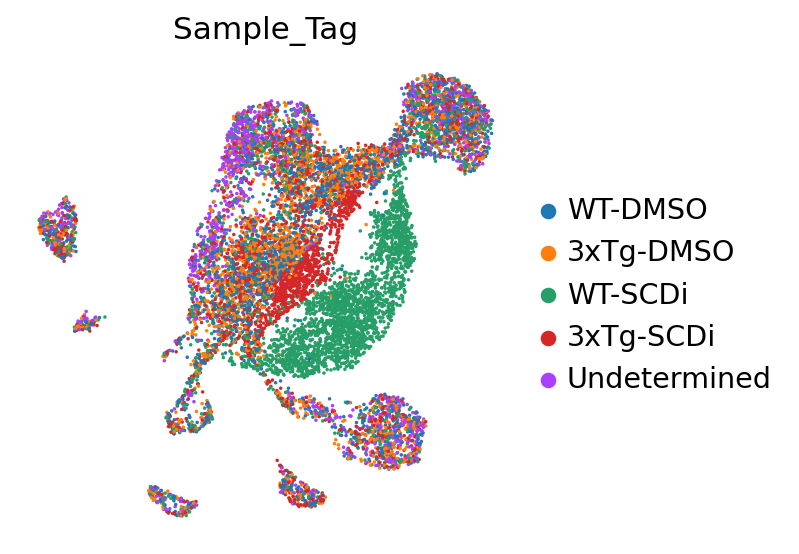

In [80]:
sc.pl.umap(adata, color=['Sample_Tag'], save='_sample_tag.png')

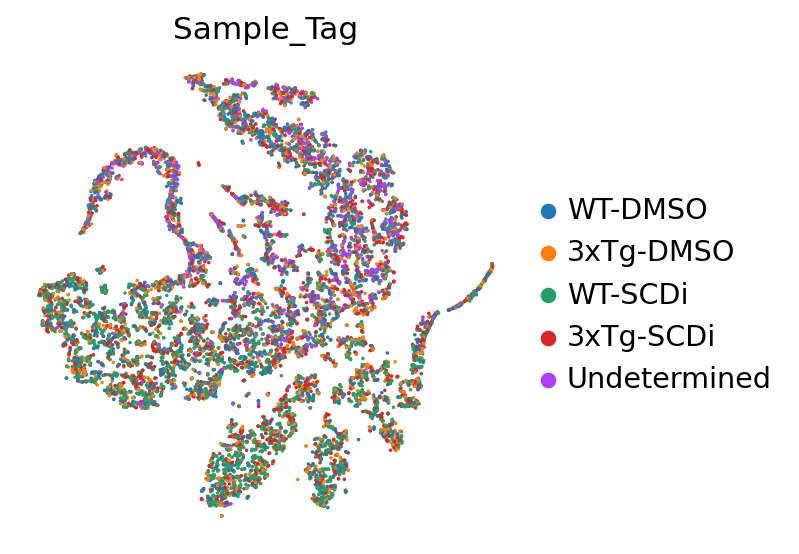

In [81]:
sc.pl.tsne(adata, color=['Sample_Tag'], save='_sample_tag.png')

### Cell type visualization

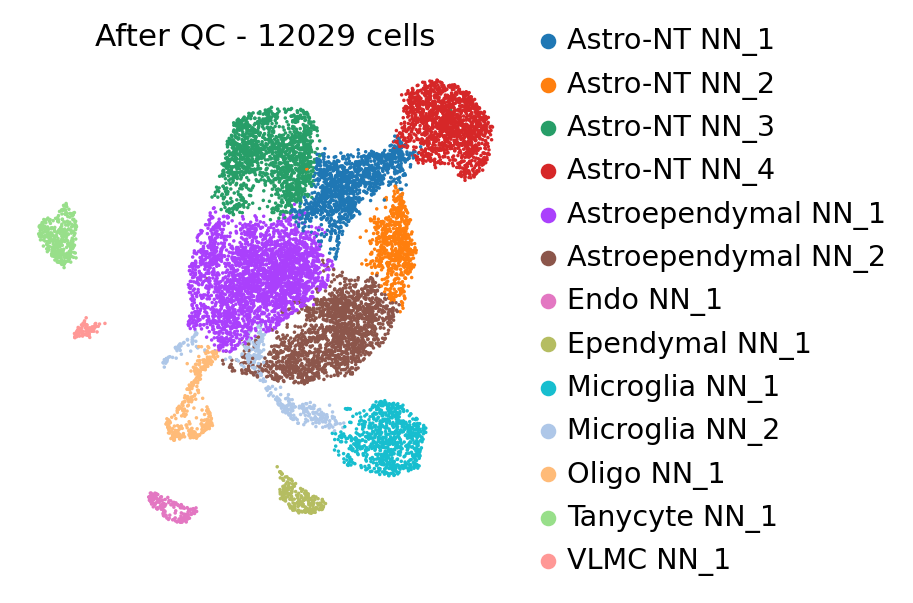

In [82]:
sc.pl.umap(adata, color=['cluster_subclass_name'], save='_subcluster_anno.png', title=f'After QC - {adata.shape[0]} cells', size=10)

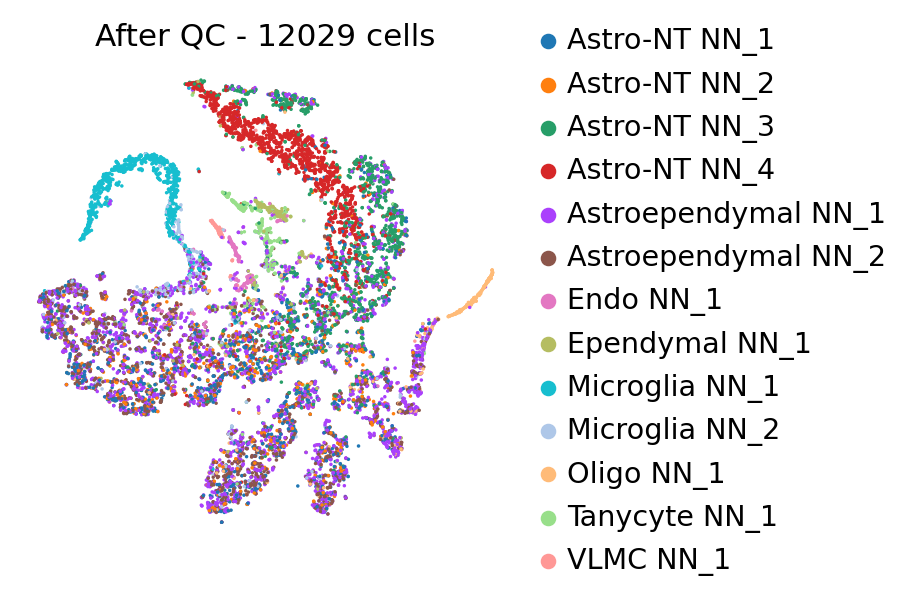

In [83]:
sc.pl.tsne(adata, color=['cluster_subclass_name'], save='_subcluster_anno.png', title=f'After QC - {adata.shape[0]} cells', size=10)

### Cell type visualization by experimental group

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


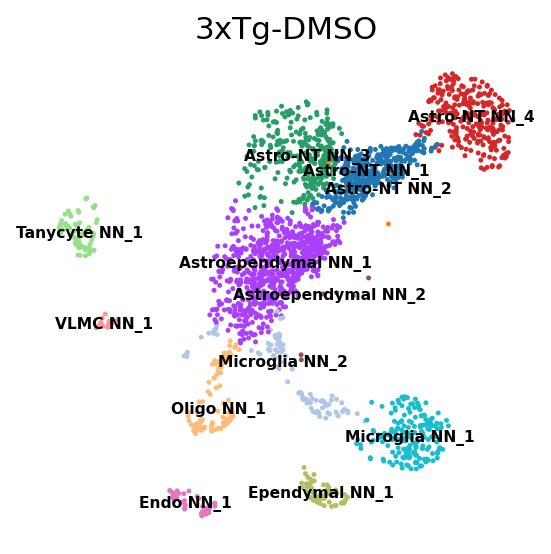

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


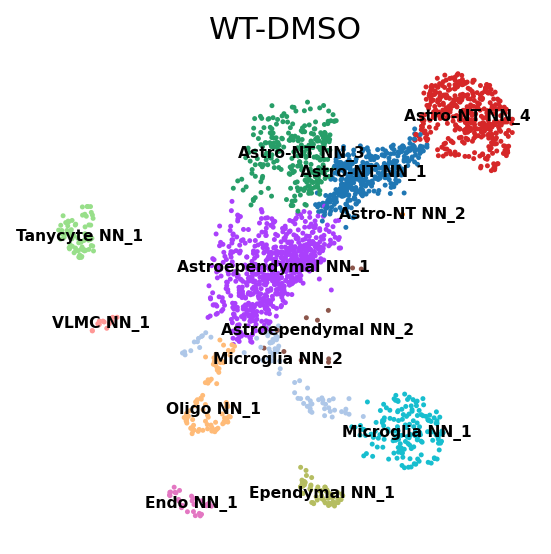

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


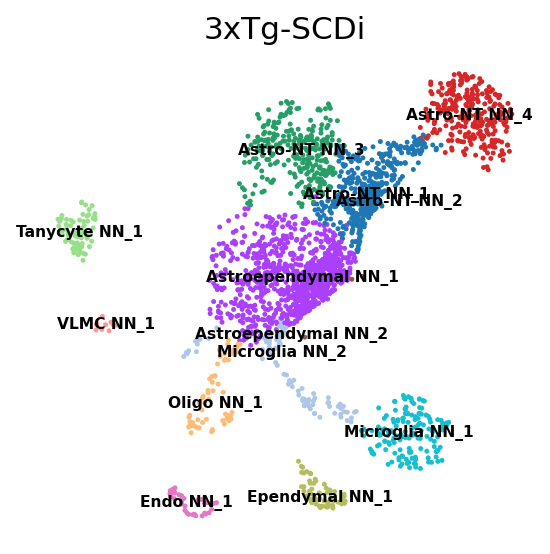

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


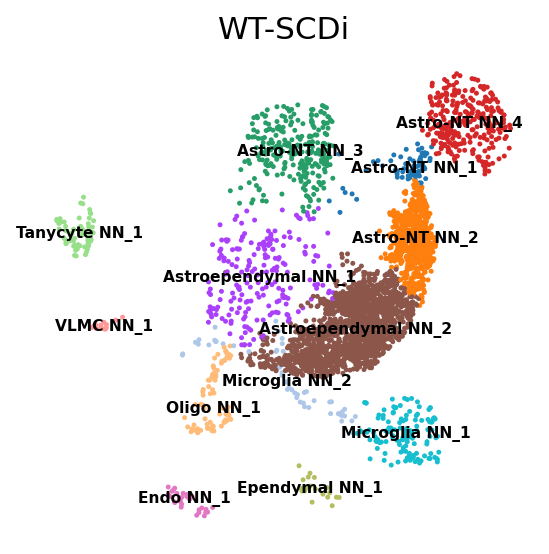

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


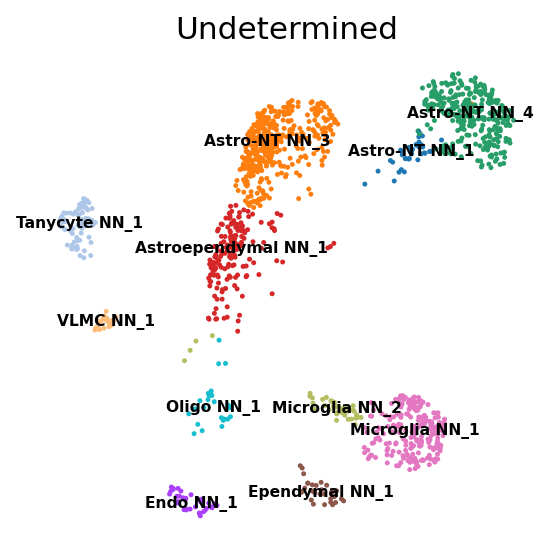

In [84]:
plot_umap(adata, cluster_type='cluster_subclass_name', legend_fontsize=7, save_path='_sample_tag')

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


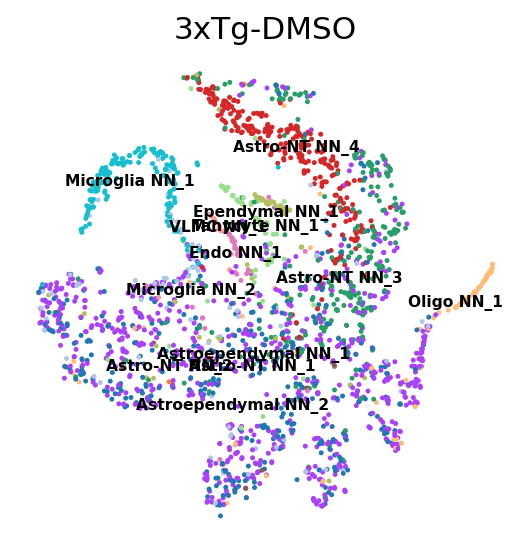

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


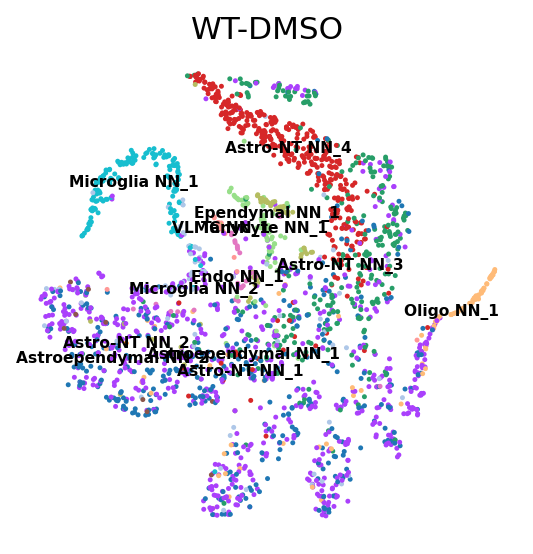

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


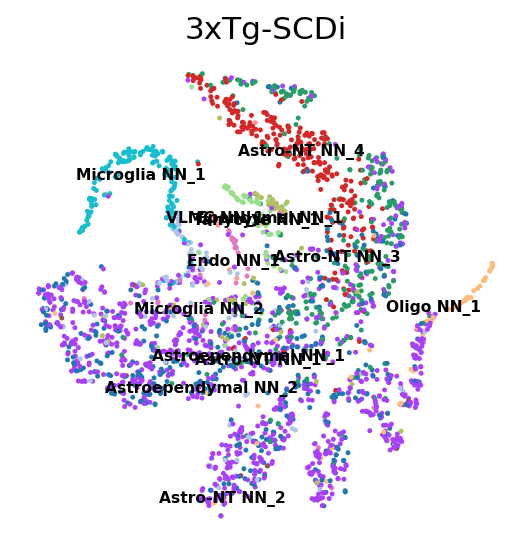

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


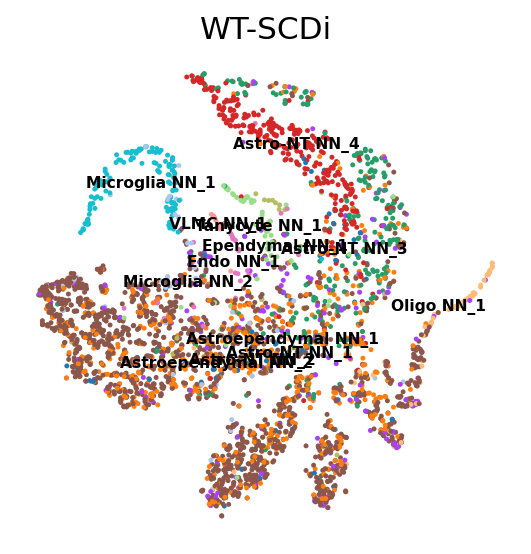

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


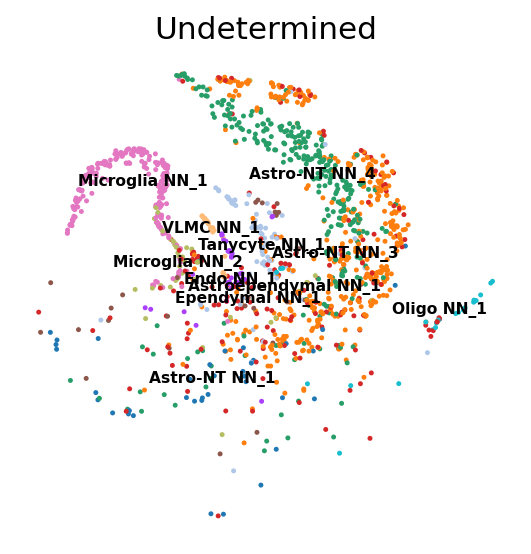

In [85]:
plot_tsne(adata, cluster_type='cluster_subclass_name', legend_fontsize=7, save_path='_sample_tag')

# Cluster homogeneity analysis

In [86]:
class_level, cluster_type = 'subclass_name', 'cluster_subclass_name'

/home/client/projects/sc_alz/modules/visualize.py:209: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  


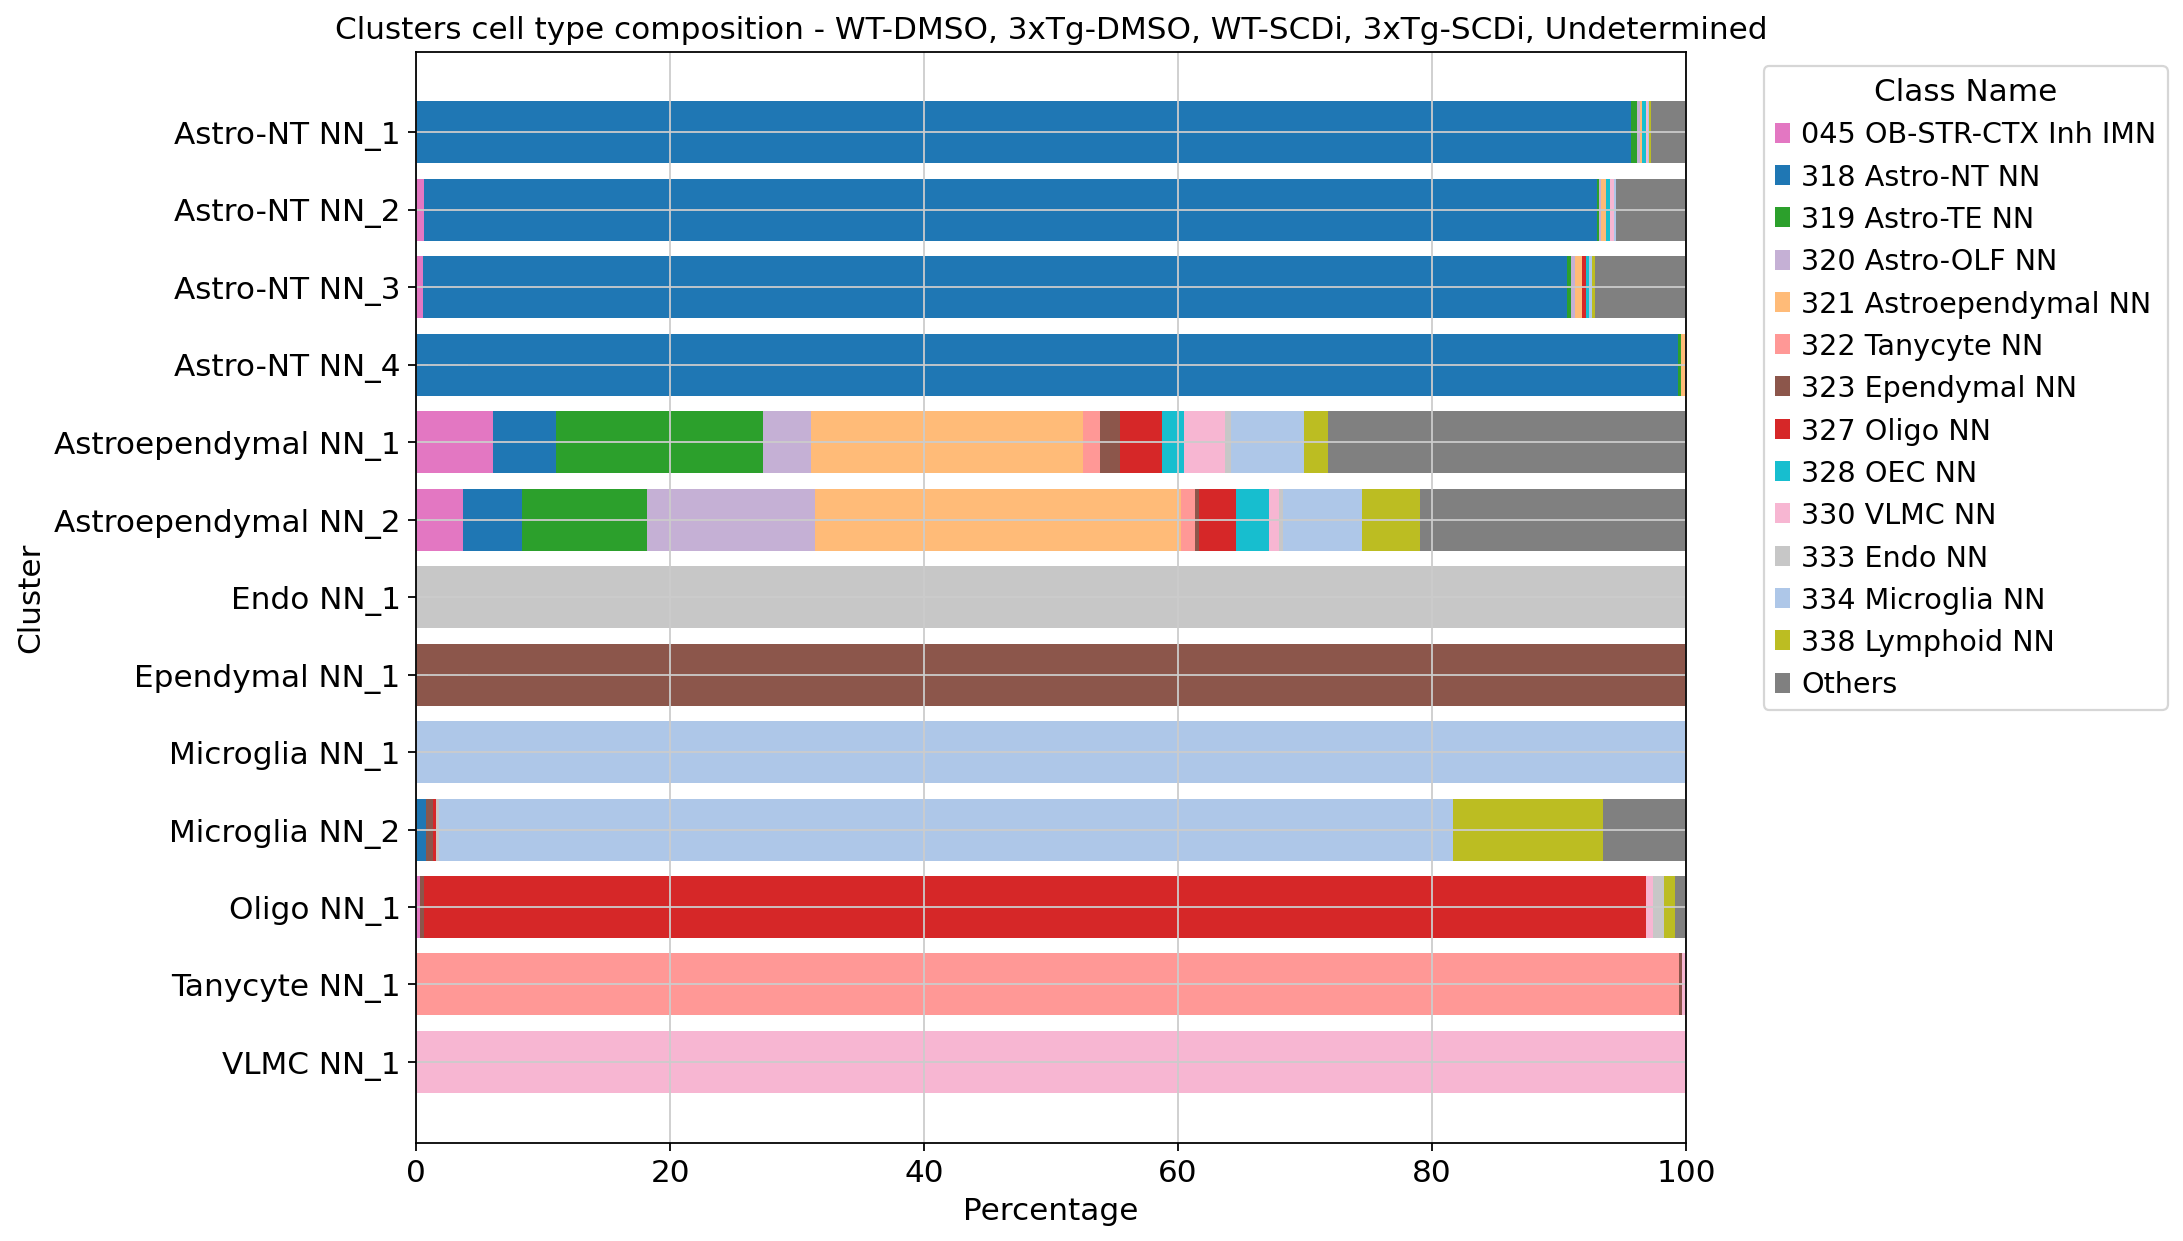

In [87]:
create_ditto_plot(adata, ['WT-DMSO', '3xTg-DMSO', 'WT-SCDi', '3xTg-SCDi', 'Undetermined'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/all_ditto.png')

In [88]:
adata.write("data/fede_count_clustered.h5ad")